# Data Mining / Prospecção de Dados 2022/2023

## André Falcão DI/FCUL 2023


## Lab class TP10 

## Summary
1. Latent Factors Recomender Systems
    1. Using SVD
    2. Implementing Stochastic Gradient Descent for Latent Factors
2. Method comparison


In [1]:
import pandas as pd
import numpy as np


## 1. Latent factor discovery with SVD

First let's create a fake reatings matrix with 10 users and 5 items. Zeros will be assumed to be missing ratings

In [2]:
np.random.seed(32)
R=np.random.randint(1, 11,[10,5])
R[R>5]=0
R

array([[0, 0, 0, 0, 4],
       [0, 0, 4, 0, 0],
       [5, 2, 4, 2, 3],
       [4, 0, 3, 5, 3],
       [5, 5, 0, 0, 0],
       [0, 0, 5, 1, 0],
       [5, 0, 1, 4, 3],
       [0, 4, 3, 0, 4],
       [3, 3, 0, 2, 5],
       [1, 5, 3, 2, 3]])

The basic idea is to produce matrices $P$ and $Q$ that can project users and items into Latent Factor space.
We will now use SVD to create the $P$ and $Q$ matrices form the original $R$ ratings matrix, where

$$U, \Sigma, V =svd(R)$$

$$ P = U $$

$$ Q = \Sigma . V^T $$

Let's test it with our sample Ratings matrix using all factors. This should replicate exactly the $R$ matrix, which in fact happens

In [3]:
from scipy.linalg import svd

U, S, V = svd(R, full_matrices=False)
#create P and Q
P=U
Q=(S*V.T).transpose()
print(np.around(P @ Q, 2))

[[-0. -0. -0. -0.  4.]
 [ 0. -0.  4.  0. -0.]
 [ 5.  2.  4.  2.  3.]
 [ 4. -0.  3.  5.  3.]
 [ 5.  5. -0. -0. -0.]
 [ 0. -0.  5.  1. -0.]
 [ 5. -0.  1.  4.  3.]
 [-0.  4.  3. -0.  4.]
 [ 3.  3. -0.  2.  5.]
 [ 1.  5.  3.  2.  3.]]


Now let's just use 2 factors and compare the overall errors

$k$ is the number of factors

In [5]:
def make_PQ(U, S, V, k):
    Uk  = U[:, :k] 
    Sk  = S[:k]
    Sdk = np.diag(Sk)
    Vk  = V[:k, :]
    P   = Uk.copy() #!
    Q   = (Sk*Vk.T).transpose()
    return P,Q

k=2
P,Q = make_PQ(U,S,V, k)
print(np.round(P @ Q, 2))


[[ 1.22  0.86  0.56  0.77  1.07]
 [-0.74  0.08  3.69  0.53  0.56]
 [ 3.6   2.8   3.49  2.72  3.71]
 [ 3.35  2.59  3.11  2.5   3.41]
 [ 3.85  2.32 -0.82  1.78  2.6 ]
 [-0.72  0.25  4.74  0.81  0.89]
 [ 4.    2.68  0.95  2.3   3.24]
 [ 1.8   1.65  3.4   1.77  2.35]
 [ 4.26  2.77  0.47  2.31  3.29]
 [ 2.68  2.2   3.37  2.21  2.99]]


We can evaluate the quality of our approximation by computing the rmse 

In [25]:
def calc_error(R, P, Q):
    return np.mean((P @ Q - R)**2)

calc_error(R, P, Q)

0.8068665501092059

#### Exercises
1. Evaluate carefully the results produced. Notice good predictions and poor ones
2. Change k and see how the results change
3. Discuss. Do you think this approach would be sufficient for making recommendations?
    1. What is the most aspect to take into account for evaluation
    2. Can you suggest a possible better implementation using only what you already know from the previous class?

In [26]:
R

array([[0, 0, 0, 0, 4],
       [0, 0, 4, 0, 0],
       [5, 2, 4, 2, 3],
       [4, 0, 3, 5, 3],
       [5, 5, 0, 0, 0],
       [0, 0, 5, 1, 0],
       [5, 0, 1, 4, 3],
       [0, 4, 3, 0, 4],
       [3, 3, 0, 2, 5],
       [1, 5, 3, 2, 3]])

In [28]:
## Exercise 2
k=3
P,Q = make_PQ(U,S,V, k)
print(np.round(P @ Q, 2))

calc_error(R, P, Q)

[[ 1.03  1.29  0.54  0.5   1.15]
 [-0.69 -0.04  3.69  0.61  0.54]
 [ 3.91  2.11  3.52  3.15  3.59]
 [ 4.58 -0.2   3.24  4.22  2.92]
 [ 3.09  4.05 -0.9   0.71  2.91]
 [-0.48 -0.28  4.77  1.14  0.8 ]
 [ 5.16  0.06  1.07  3.92  2.79]
 [ 0.55  4.47  3.27  0.02  2.84]
 [ 3.9   3.57  0.43  1.81  3.43]
 [ 1.66  4.49  3.26  0.79  3.38]]


0.8068665501092059

## 1.2. A Stochastic gradient descent for Recomender Systems

One of the important things we need to take into account is a proper evaluation function. Assuming Zeros  for the SVD is ok, but we should not evaluate how far away we are from those predictions, so a better function that only takes into account the actual ratings would be important to implement. 

This could be implemented going through all non zero elements in our ratings matrix and evaluating only the errors there, but a probably faster approach would be to more or less the same as before bu apply a 0,1 mask to only the elements that have a rating.

This could be easily accomplished in numpy as this

In [20]:
mask=1*(R>0)
print(mask)

[[0 0 0 0 1]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [1 0 1 1 1]
 [1 1 0 0 0]
 [0 0 1 1 0]
 [1 0 1 1 1]
 [0 1 1 0 1]
 [1 1 0 1 1]
 [1 1 1 1 1]]


As such a better evaluation could be accomplished simply multiplying the scores by the mask

In [29]:
def calc_error_mask(R, P, Q, mask):
    return np.mean((R-(P @ Q)*mask)**2)


Let's evaluate our SVD projections with this new approach

In [65]:
for k in range(2,6):
    P,Q =make_PQ(U, S, V, k)
    print(k, "-->%7.4f" % calc_error_mask(R, P, Q, mask))

2 --> 1.1181
3 --> 0.4941
4 --> 0.0997
5 --> 0.0000


Now we have a proper evaluation function, we can now think about changing the factors using gradient descent. We know from class that we want to minimze this value (which is actually the `calc_error` function described

$$ \min_{P,Q} \sum(r_{ui} - q_i.p^T_u) ^2 $$

Using gradient descent we need to update the P and Q entries this way

$$ P_t = P_{t-1} - \eta\nabla P $$


$$ Q_t = Q_{t-1} - \eta\nabla Q $$

Where $\eta$ is a learning rate and $\nabla p$ and $\nabla Q$ are the partial derivatives of $P$ and $Q$, respectively.
 The partial derivatives of each element of the $R$ matrix for each user (u) and item (i) is computed as

$$ \Delta_{ui} = 2(r_{ui} - q_i.p^T_u) $$

and we this can update each row of $P$ and $Q^T$ this way:

$$ p_u = p_u + \eta \Delta_{ui} q_i  $$
$$ q_i = q_i + \eta \Delta_{ui} p_u $$


### An example 

Let's assume a learning rate of 0.1 and check the prediction for user 0, and item 4. We will crete our $P$ and $Q$ factors with $k=2$  


In [74]:
k=2
u=0
i=4
P,Q =make_PQ(U, S, V, k)
print("pu:", P[u, :])
print("qi:", Q[:, i])

print("The MSE is:", calc_error_mask(R, P, Q, mask))

with np.printoptions(precision=3):
    print("P factor")
    print(P)
    print("Q factor")
    print(Q)

pu: [-0.12563859 -0.04101084]
qi: [-8.35855153 -0.54594322]
The MSE is: 1.1181015932985061
P factor
[[-0.126 -0.041]
 [-0.098  0.479]
 [-0.449  0.089]
 [-0.412  0.067]
 [-0.284 -0.42 ]
 [-0.145  0.596]
 [-0.373 -0.232]
 [-0.296  0.231]
 [-0.373 -0.308]
 [-0.367  0.153]]
Q factor
[[-8.668 -6.461 -6.515 -6.077 -8.359]
 [-3.315 -1.153  6.373 -0.127 -0.546]]


Now let's update the factors according to stochastic gradient descent for only this rating

In [75]:
LR=.005
u=0
i=4
r_ui=R[u,i]

#derivative at (0,4)
delta = 2*(r_ui - P[u,:] @ Q[:, i] )

#here's the critical bit - We will update P and Q according to the learning rate and the derivative
Q[:, i] = Q[:, i] + LR*delta*P[u,:]
P[u, :] = P[u, :] + LR*delta*Q[:, i]

#Let's see what was changed and compute the MSE
print("pu:", P[u, :])
print("qi:", Q[:, i])

print("The MSE is:", calc_error_mask(R, P, Q, mask))
with np.printoptions(precision=3):
    print("P factor")
    print(P)
    print("Q factor")
    print(Q)


pu: [-0.37043899 -0.05702822]
qi: [-8.36222955 -0.5471438 ]
The MSE is: 0.9617881605210967
P factor
[[-0.37  -0.057]
 [-0.098  0.479]
 [-0.449  0.089]
 [-0.412  0.067]
 [-0.284 -0.42 ]
 [-0.145  0.596]
 [-0.373 -0.232]
 [-0.296  0.231]
 [-0.373 -0.308]
 [-0.367  0.153]]
Q factor
[[-8.668 -6.461 -6.515 -6.077 -8.362]
 [-3.315 -1.153  6.373 -0.127 -0.547]]


Now we need to run all the ratings, but in a shuffled form so that we do not end up in local optima cuased by the data ordering, so we will `shuffle` all ratings before procedeing. We will call running SGD for all items one epoch

In [76]:
from random import shuffle
LR=0.005
def run_epoch(elems, R, P, Q, LR):
    shuffle(elems)
    for u,i in elems:
        r_ui=R[u,i]
        delta = 2*(r_ui - P[u,:] @ Q[:, i] )
        Q[:, i] = Q[:, i] + LR*delta*P[u,:]
        P[u, :] = P[u, :] + LR*delta*Q[:, i]
    return P,Q

rated_elements = [(u,i) for u, i in np.argwhere(R>0)]
run_epoch(rated_elements, R, P, Q, LR)

print("The MSE is:", calc_error_mask(R, P, Q, mask))
with np.printoptions(precision=3):
    print("P factor")
    print(P)
    print("Q factor")
    print(Q)

The MSE is: 0.8712383532659742
P factor
[[-0.443 -0.062]
 [-0.118  0.499]
 [-0.567  0.042]
 [-0.432  0.045]
 [-0.513 -0.481]
 [-0.169  0.607]
 [-0.463 -0.28 ]
 [-0.451  0.121]
 [-0.508 -0.287]
 [-0.243  0.215]]
Q factor
[[-8.671 -6.485 -6.509 -6.087 -8.358]
 [-3.317 -1.156  6.375 -0.132 -0.553]]


Finally we can run several epochs at once in a simple convenient function, for which we just have to specify k, the learning rate and the number of epochs to run


In [77]:
def RecSys_SGD(R, num_epochs=100, k=2, LR=0.01, output_mses=False):
    #initialization
    MSEs=[]
    U, S, V = svd(R, full_matrices=False)
    P,Q = make_PQ(U,S,V, k)
    mask=1*(R>0)
    rated_elements = [(u,i) for u, i in np.argwhere(R>0)]
    #run all the epochs
    for i in range(num_epochs):
        P,Q = run_epoch(rated_elements, R, P, Q, LR)
        mse = calc_error_mask(R, P, Q, mask)
        MSEs.append(mse)
        
    if output_mses: 
        return P,Q, MSEs
    return P,Q

Let's test our implementation

In [192]:

P,Q, mses = RecSys_SGD(R, num_epochs=100, k=2, LR=0.01, output_mses=True)
print("The MSE is:", calc_error_mask(R, P, Q, mask))
with np.printoptions(precision=3):
    print("P factor")
    print(P)
    print("Q factor")
    print(Q)

The MSE is: 0.5950192797800476
P factor
[[-1.928  0.092]
 [-1.415  1.298]
 [-1.614  0.051]
 [-1.883 -0.424]
 [-2.373 -0.172]
 [-1.483  1.528]
 [-1.671 -0.982]
 [-1.774  0.275]
 [-1.636  0.288]
 [-1.37   0.705]]
Q factor
[[-1.846 -1.791 -1.508 -1.477 -1.754]
 [-0.661  0.477  0.983 -0.634  0.261]]


In [139]:
from tqdm.notebook import tqdm

In [173]:
results = {}
lr_values = [0.05, 0.01, 0.005, 0.002, 0.001]
k_values = [2,3,4,5]

for k_v in tqdm([2,3,4,5]):
    for lr in [0.05, 0.01, 0.005, 0.002, 0.001]:
        values = []
        for n in range(15):
            P,Q, mses = RecSys_SGD(R, num_epochs=100, k=3, LR=0.005, output_mses=True)
            values.append(calc_error_mask(R,P,Q,mask))
        results[(k_v, lr)] = np.mean(values)

In [165]:
filter_k = lambda res, k: dict(filter(lambda x: x[0][0]==k, results.items()))

In [166]:
filter_k(results, 2)

{(2, 0.05): 0.18380511154381432,
 (2, 0.01): 0.19031646924430187,
 (2, 0.005): 0.1930502733152297,
 (2, 0.002): 0.1919314345180867,
 (2, 0.001): 0.19913330143161545}

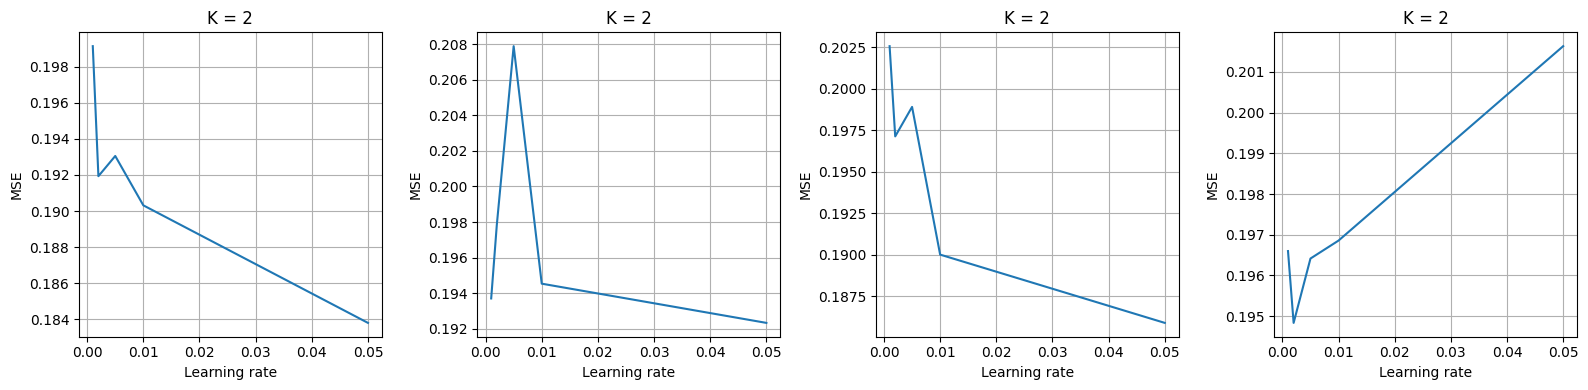

In [182]:
f, ax = plt.subplots(1,4, figsize=(16,4))

for i, a in enumerate(ax):
    data = filter_k(results, i+2)
    a.plot( list(map(lambda x: x[1], data)), data.values())
    a.set_title(f"K = {k_v}")
    a.set_xlabel("Learning rate")
    a.set_ylabel("MSE")
    a.grid()
f.tight_layout()

Let's visualise the convergence errors, with the `output_mses = True` that will show the actual MSEs of the the convergence process


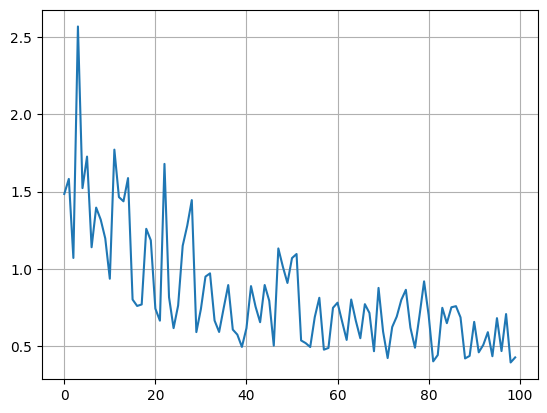

In [112]:
import matplotlib.pyplot as plt
plt.plot(mses)
plt.grid()
plt.show()

#### Exercises
1. change the learning rate and k and verify a better choice for those parameters. Discuss your results


### Regularized Stochastic Gradient Descent

We can have better results with SGD if we penalize the size of the factors in the P and Q matrices

$$ \min_{P,Q} \sum(r_{ui} - q_i.p^T_u) ^2 + \lambda\left[ \sum_u||p_u|| + \sum_i||q_i|| \right]$$

As such the partial derivatives change 

$$ \nabla Q_{ik} = \sum\left(-2(r_{ui} - q_i.p^T_u)p_{uk} + 2\lambda_q q_{ik} \right) $$

$$ \nabla P_{uk} = \sum\left(-2(r_{ui} - q_i.p^T_u)q_{ik} + 2\lambda_p p_{uk} \right) $$

But with this the update procedure is exactly the same as above, so we just need to update our `run_epoch`function with 2 new parameters for the regularization constants to apply


In [186]:
def run_epoch_reg(elems, R, P, Q, LR, Lp=1, Lq=1):
    shuffle(elems)
    for u,i in elems:
        r_ui=R[u,i]
        delta = 2*(r_ui - P[u,:] @ Q[:, i] )
        Q[:, i] = Q[:, i] + LR*(delta*P[u,:] - Lq*Q[:,i])
        P[u, :] = P[u, :] + LR*(delta*Q[:, i]- Lp*P[u, :])
    return P,Q


#we update our RecSys function with the Lambdas for the regularization
def RecSys_SGD(R, num_epochs=100, k=2, LR=0.01, Lp=1, Lq=1, output_mses=False):
    #initialization
    MSEs=[]
    U, S, V = svd(R, full_matrices=False)
    P,Q = make_PQ(U,S,V, k)
    mask=1*(R>0)
    rated_elements = [(u,i) for u, i in np.argwhere(R>0)]
    #run all the epochs
    for i in range(num_epochs):
        P,Q = run_epoch_reg(rated_elements, R, P, Q, LR)
        mse = calc_error_mask(R, P, Q, mask)
        MSEs.append(mse)
    if output_mses==False: return P,Q
    else: return P,Q, MSEs



Now let's look at our factors regularized and the impact in the overal error function

In [193]:
regP,regQ, mses = RecSys_SGD(R, num_epochs=100, k=2, LR=0.01, output_mses=True)
print("The MSE is:", calc_error_mask(R, P, Q, mask))
with np.printoptions(precision=3):
    print("P factor")
    print(regP)
    print("Q factor")
    print(regQ)

The MSE is: 0.5950192797800476
P factor
[[-1.936  0.081]
 [-1.412  1.301]
 [-1.615  0.073]
 [-1.9   -0.413]
 [-2.372 -0.182]
 [-1.477  1.535]
 [-1.681 -0.971]
 [-1.782  0.264]
 [-1.646  0.288]
 [-1.358  0.691]]
Q factor
[[-1.832 -1.8   -1.522 -1.503 -1.783]
 [-0.653  0.449  0.993 -0.621  0.265]]


In [194]:
with np.printoptions(precision=3):
    print("P factor")
    print(P)
    print("Q factor")
    print(Q)

P factor
[[-1.928  0.092]
 [-1.415  1.298]
 [-1.614  0.051]
 [-1.883 -0.424]
 [-2.373 -0.172]
 [-1.483  1.528]
 [-1.671 -0.982]
 [-1.774  0.275]
 [-1.636  0.288]
 [-1.37   0.705]]
Q factor
[[-1.846 -1.791 -1.508 -1.477 -1.754]
 [-0.661  0.477  0.983 -0.634  0.261]]


#### Exercises
1. Compare in values the results P and Q matrices of the regularized approach and comment upon
2. Evaluate the impact of changing the lambdas in the overall results

In [197]:
results = {}

l_v = [0, 0.5, 1.5, 5, 10]
for lp in tqdm(l_v):
    for lq in l_v:
        regP,regQ, mses = RecSys_SGD(R, num_epochs=100, k=2, LR=0.01, output_mses=True, Lq=lq, Lp=lp)
        results[(lp,lq)] = calc_error_mask(R,regP,regQ, mask)



  0%|          | 0/5 [00:00<?, ?it/s]

In [199]:
filter_k(results, 0)

{(0, 0): 0.5698153299097202,
 (0, 0.5): 0.5739894907037075,
 (0, 1.5): 0.5667944511940709,
 (0, 5): 0.5912088974443113,
 (0, 10): 0.5584113415317123}

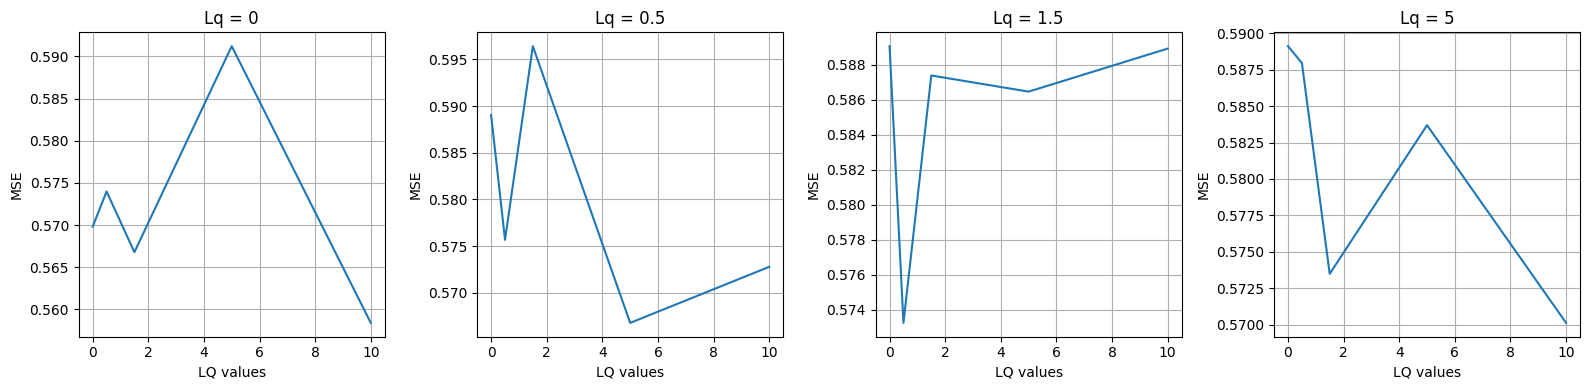

In [202]:
f, ax = plt.subplots(1,4, figsize=(16,4))

for i, a in enumerate(ax):
    data = filter_k(results, l_v[i])
    a.plot( list(map(lambda x: x[1], data)), data.values())
    a.set_title(f"Lq = {l_v[i]}")
    a.set_xlabel("LQ values")
    a.set_ylabel("MSE")
    a.grid()
f.tight_layout()

## Testing on larger problem

We are going to use a larger problem from last class with about 100,000 ratings from 9,700 users and 609 items

First import the data

In [ ]:
import pandas as pd
rawdata=pd.read_csv("ratings.csv")
rawdata

Now create the R matrix for analysis

In [ ]:
def create_rankingMatrix(rowLabel, colLabel, df):
    rows = list(set(rawdata[rowLabel])) 
    cols = list(set(rawdata[colLabel])) 
    n_rows = len(rows)
    n_cols = len(cols)

    rows = dict(zip(rows, np.arange(n_rows)))
    cols = dict(zip(cols, np.arange(n_cols)))
    mat = np.zeros((n_rows, n_cols))
    #mat[mat==0]=np.nan  #this will be different from previous class
    for rw in df.values:
        mat[rows[rw[0]], cols[rw[1]]]=rw[2]
    return mat

mat=create_rankingMatrix("userId", "movieId", rawdata)
mat=mat.T
pd.DataFrame(mat)

#### Exercises
1. Try finding the latent factors for analysis with full matrix
2. Save some ratings for testing and evaluate the best combination of settings
